In [2]:
import os
import cv2
import numpy as np
import pathlib
from matplotlib import pyplot as plt

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

def show(data):
	plt.xticks([])
	plt.yticks([])
	plt.imshow(data)
	plt.show()

def printArrayInfo(arr):
	print("---------------------------")
	print("Size :: ", arr.size)
	print("Shape :: ", arr.shape)
	print("---------------------------")

2023-01-07 21:19:22.986475: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:

dataDir = pathlib.Path("dataPostProcessed")
imageCount = len(list(dataDir.glob('*/*.jpg')))
print(imageCount)

batch_size = 32
img_height = 184
img_width = 187

12532


# Dataset

In [4]:
train_ds = tf.keras.utils.image_dataset_from_directory(
	dataDir,
	validation_split=0.2,
	subset="training",
	seed=76523,
	image_size=(img_height, img_width),
	batch_size=batch_size)

Found 12532 files belonging to 52 classes.
Using 10026 files for training.


2023-01-07 21:19:44.606911: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
val_ds = tf.keras.utils.image_dataset_from_directory(
	dataDir,
	validation_split=0.2,
	subset="validation",
	seed=76523,
	image_size=(img_height, img_width),
	batch_size=batch_size)

Found 12532 files belonging to 52 classes.
Using 2506 files for validation.


In [6]:
class_names = train_ds.class_names
for id, c in enumerate(class_names):
	class_names[id] = c.split("_")[0]
print(class_names)

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


# Visualize

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
	for i in range(9):
		ax = plt.subplot(3, 3, i + 1)
		plt.imshow(images[i].numpy().astype("uint8"))
		plt.title(class_names[labels[i]])
		plt.axis("off")

# Performance

In [7]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Model

In [8]:
num_classes = len(class_names)

model = Sequential([
	layers.Rescaling(1./255, input_shape=(img_height, img_width, 3), name="rescaleImage"),
	layers.Conv2D(16, 3, padding='same', activation='relu'),
	layers.MaxPooling2D(),
	layers.Conv2D(32, 3, padding='same', activation='relu'),
	layers.MaxPooling2D(),
	layers.Conv2D(64, 3, padding='same', activation='relu'),
	layers.MaxPooling2D(),
	layers.Dropout(0.2),
	layers.Flatten(),
	layers.Dense(128, activation='relu'),
	layers.Dense(num_classes, name="output")
], name='imageClassification')

# Compile

In [9]:
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
model.summary()

Model: "imageClassification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaleImage (Rescaling)    (None, 184, 187, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 184, 187, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 92, 93, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 92, 93, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 46, 46, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 46, 46, 64)

# Train

In [10]:
epochs=15
history = model.fit(
	train_ds,
	validation_data=val_ds,
	epochs=epochs
)

Epoch 1/15
314/314 [==============================] - 148s 456ms/step - loss: 1.8967 - accuracy: 0.5298 - val_loss: 0.3365 - val_accuracy: 0.9050
Epoch 2/15
314/314 [==============================] - 171s 544ms/step - loss: 0.1241 - accuracy: 0.9671 - val_loss: 0.0960 - val_accuracy: 0.9681
Epoch 3/15
314/314 [==============================] - 159s 507ms/step - loss: 0.0481 - accuracy: 0.9860 - val_loss: 0.0571 - val_accuracy: 0.9812
Epoch 4/15
314/314 [==============================] - 150s 478ms/step - loss: 0.0242 - accuracy: 0.9931 - val_loss: 0.0427 - val_accuracy: 0.9868
Epoch 5/15
314/314 [==============================] - 144s 458ms/step - loss: 0.0303 - accuracy: 0.9922 - val_loss: 0.0982 - val_accuracy: 0.9792
Epoch 6/15
314/314 [==============================] - 150s 474ms/step - loss: 0.0593 - accuracy: 0.9823 - val_loss: 0.0753 - val_accuracy: 0.9741
Epoch 7/15
314/314 [==============================] - 155s 493ms/step - loss: 0.0265 - accuracy: 0.9926 - val_loss: 0.0463 -

# Viz

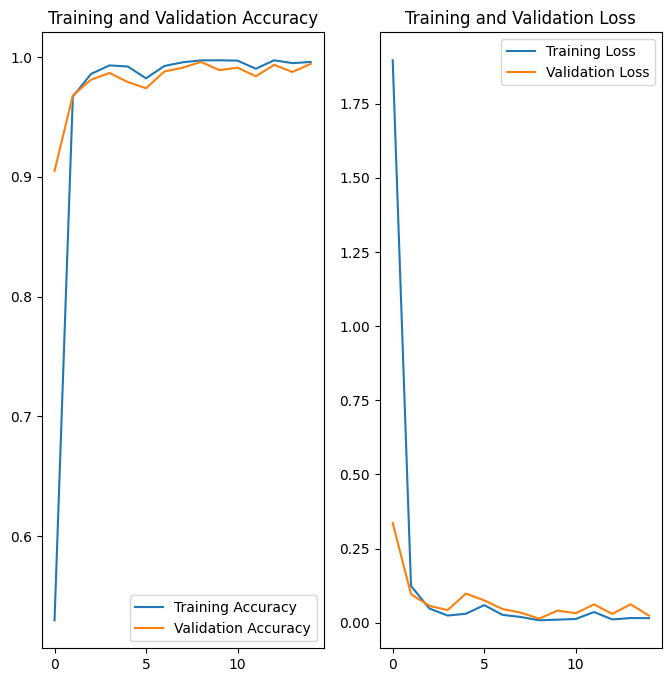

In [11]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

1/1 [==============================] - 1s 606ms/step
Score: 0.999996542930603 | Position: 31 | Letter: f


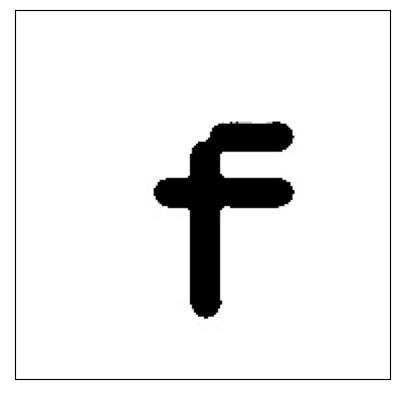

In [12]:
samplePath = pathlib.Path("dataTestProcessed/3_1_1.jpg")

img = tf.keras.utils.load_img( samplePath, target_size=(img_height, img_width) )
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print("Score: {} | Position: {} | Letter: {}".format(np.max(score), np.argmax(score), class_names[np.argmax(score)]))
show(img)

# Save

In [13]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('imageClassificationModel.tflite', 'wb') as f:
	f.write(tflite_model)

INFO:tensorflow:Assets written to: /var/folders/zz/cdkl7mtd2hzgf6sdzm56xmkc0000gn/T/tmp32852rqe/assets


INFO:tensorflow:Assets written to: /var/folders/zz/cdkl7mtd2hzgf6sdzm56xmkc0000gn/T/tmp32852rqe/assets
2023-01-07 22:20:11.252581: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2023-01-07 22:20:11.253578: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2023-01-07 22:20:11.265852: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /var/folders/zz/cdkl7mtd2hzgf6sdzm56xmkc0000gn/T/tmp32852rqe
2023-01-07 22:20:11.268673: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2023-01-07 22:20:11.268699: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /var/folders/zz/cdkl7mtd2hzgf6sdzm56xmkc0000gn/T/tmp32852rqe
2023-01-07 22:20:11.282753: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:357] MLIR V1 optimization pass is not enabled
2023-01-07 22:20:11.285486: I tensorflow/cc/saved_model/load

# Lite model

In [14]:
TF_MODEL_FILE_PATH = "imageClassificationModel.tflite"

interpreter = tf.lite.Interpreter(model_path=TF_MODEL_FILE_PATH)

print(interpreter.get_signature_list())

classify_lite = interpreter.get_signature_runner('serving_default')
classify_lite

{'serving_default': {'inputs': ['rescaleImage_input'], 'outputs': ['output']}}


In [15]:
img = tf.keras.utils.load_img( samplePath, target_size=(img_height, img_width) )
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions_lite = classify_lite(rescaleImage_input=img_array)['output']
score_lite = tf.nn.softmax(predictions_lite)

print("Score: {} | Position: {} | Letter: {}".format(np.max(score_lite), np.argmax(score_lite), class_names[np.argmax(score_lite)]))

Score: 0.999996542930603 | Position: 31 | Letter: f
